Notas:
- pensar cómo voy a usar esto: si lo voy a validar con un modelo predictivo, estaría bueno separar un held-out (esto debería hacerlo incluso antes que la nb 03, y dejarlo para contrastar los 3 métodos)
- leer sobre NB y LR en Jurafsky para poner una explicación linda sobre los pesos asignados a las palabras
  
Next steps:
- gráficos del feature importance

# Classifier based

In [236]:
import os
import re
from typing import Any
from string import punctuation

import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV

In [139]:
here = os.getcwd()
project_path = os.path.dirname(here)
data_path = os.path.join(project_path, "data", "session_speech.csv")

In [140]:
data = pd.read_csv(data_path, converters={"speech":eval})
data.columns

Index(['name', 'vote', 'speech'], dtype='object')

In [141]:
data = data.explode(column="speech")
data = data[(data.speech.notna()) & (~data.vote.isin(["abstención", "ausente"]))]
data.shape

(199, 3)

In [142]:
data.vote.value_counts(normalize=True)

vote
positivo    0.557789
negativo    0.442211
Name: proportion, dtype: float64

In [143]:
le = LabelEncoder()

X = data.speech
y = le.fit_transform(data.vote)

# Pipeline

In [144]:
def preprocess(text: str) -> str:
    text = text.lower()
    text = re.sub(rf"[{punctuation}\“\”\¿\¡\−\…]", " ", text)
    text = re.sub(r"\d+", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

In [145]:
def build_pipeline(pipeline_steps: list[tuple[str,Any]]) -> Pipeline:
    pipeline = Pipeline(pipeline_steps)
    return pipeline


def build_gridsearch(clf: Any, clf_params: dict[str, list]) -> GridSearchCV:
    params = {
        "tfidf__min_df": [0.1, 0.3, 0.5, 0.7],
        "tfidf__norm": ["l1", "l2"],
        "tfidf__smooth_idf": [False, True],
        "tfidf__sublinear_tf": [False, True],
        "tfidf__min_df": [0.05, 0.1],
        **clf_params
    }
    pipeline = build_pipeline([
        (
            'tfidf',
            TfidfVectorizer(
                lowercase=True,
                preprocessor=preprocess
            )
        ),
        (
            'clf',
            clf
        )
    ])
    return GridSearchCV(
        pipeline,
        params,
        scoring='f1',
        cv=5,
        return_train_score=True,
        n_jobs=-1
    )


def build_results_df(cv_results: dict[str, np.ndarray]) -> pd.DataFrame:
    df_cv_results = pd.DataFrame(cv_results)
    param_cols = df_cv_results.filter(regex="param_").columns.tolist()
    df_cv_results.drop(columns=param_cols, inplace=True)
    df_cv_results["params"] = (
        df_cv_results
        .params
        .apply(lambda x: "-".join([f"{k}={v}" for k, v in x.items()]))
    )
    df_cv_results.set_index("params", inplace=True)
    df_cv_results.sort_values(by="rank_test_score", inplace=True)
    df_cv_results = df_cv_results[df_cv_results.columns.sort_values().tolist()]
    return df_cv_results


def build_results_df2plot(results_df: pd.DataFrame) -> pd.DataFrame:
    split_cols = results_df.filter(regex=r"(split\d+\_test)").columns.to_list()
    return (
        pd.concat([
            results_df.nlargest(3, "mean_test_score"),
            results_df.nsmallest(3, "std_test_score")
        ])
        .drop_duplicates(keep="first")
        .reset_index()
        .melt(
            id_vars = ["params"],
            value_vars = split_cols,
            var_name = "measure"
        )
        .merge(
            results_df[["mean_test_score", "std_test_score"]],
            left_on = "params", right_index = True
        )
        .reset_index(drop=True)
    )


def plot_results(results_df2plot: pd.DataFrame, clf: str, file_name: str) -> None:
    fig, axs = plt.subplots(1, 2, figsize=(9,3))
    for params, df in results_df2plot.groupby("params"):
        _df = df[["params", "mean_test_score", "std_test_score"]].drop_duplicates(keep="first")
        axs[0].errorbar(
            x=_df.mean_test_score,
            xerr=_df.std_test_score,
            y=_df.params,
            fmt="o",
            label=params
        )
        axs[1].errorbar(
            x=df.measure,
            y=df.value,
            label=params
        )
    axs[0].set_yticklabels("F1 score")
    axs[0].set_yticks([])
    axs[0].set_xlabel("")
    axs[0].set_title("Promedio y desvío")
    axs[1].set_xticklabels([
        "split {n}".format(n=re.search(r'\d+', label.get_text()).group())
        for label in axs[1].get_xticklabels()
    ])
    axs[1].set_xlabel("")
    axs[1].set_title("Por split")
    title = fig.suptitle(f"{clf}: F1-score en test en validación cruzada", y=1.1)
    lgd = plt.legend(loc="lower center", bbox_to_anchor=(-0.1, -0.8))

    fig.savefig(
    f"{project_path}/visualizations/{file_name}.png",
    bbox_extra_artists=[lgd,title], bbox_inches='tight'
)

def print_best_estimator_info(gs_estimators: GridSearchCV) -> None:
    best_params = "\n\t-- ".join(
        [f"{k}: {v}" for k, v in gs_estimators.best_params_.items()]
    )
    print(f"""
    - Best Cross-Validation score : {gs_estimators.best_score_}
    - Best parameters set:\n\t-- {best_params}
    """)

## Multinomial Naive Bayes

In [146]:
nb_gridsearch = build_gridsearch(
    clf=MultinomialNB(),
    clf_params={"clf__alpha": [0.01, 0.1, 1.0]}
)
nb_gridsearch.fit(X, y)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(preprocessor=<function preprocess at 0x7f690c9a5e10>)),
                                       ('clf', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'clf__alpha': [0.01, 0.1, 1.0],
                         'tfidf__min_df': [0.05, 0.1],
                         'tfidf__norm': ['l1', 'l2'],
                         'tfidf__smooth_idf': [False, True],
                         'tfidf__sublinear_tf': [False, True]},
             return_train_score=True, scoring='f1')

In [158]:
nb_gridsearch_cv_results = build_results_df(nb_gridsearch.cv_results_)
nb_gridsearch_cv_results.iloc[0]

mean_fit_time         0.206352
mean_score_time       0.049342
mean_test_score       0.710245
mean_train_score      0.798179
rank_test_score       1.000000
split0_test_score     0.730159
split0_train_score    0.783069
split1_test_score     0.636364
split1_train_score    0.798030
split2_test_score     0.733333
split2_train_score    0.826291
split3_test_score     0.808511
split3_train_score    0.800000
split4_test_score     0.642857
split4_train_score    0.783505
std_fit_time          0.042448
std_score_time        0.017874
std_test_score        0.064164
std_train_score       0.015731
Name: clf__alpha=1.0-tfidf__min_df=0.05-tfidf__norm=l2-tfidf__smooth_idf=True-tfidf__sublinear_tf=False, dtype: float64

/tmp/ipykernel_40344/2541986544.py:91: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_yticklabels("F1 score")
/tmp/ipykernel_40344/2541986544.py:95: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_xticklabels([


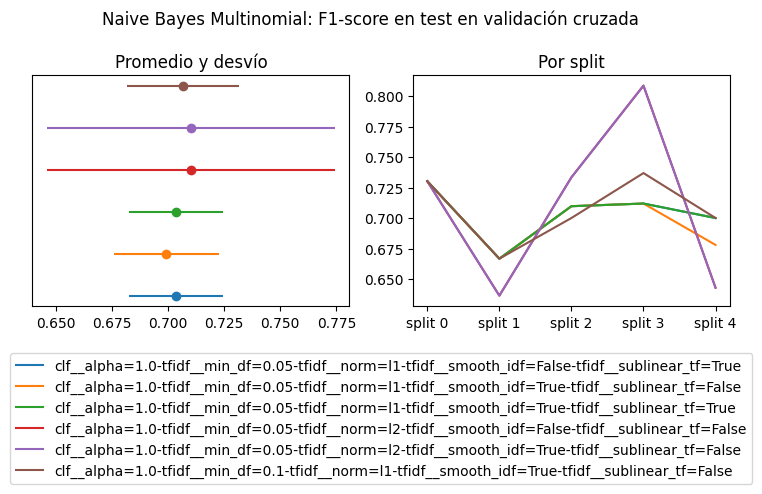

In [159]:
nb_gridsearch_cv_results2plot = build_results_df2plot(nb_gridsearch_cv_results)
plot_results(nb_gridsearch_cv_results2plot, clf="Naive Bayes Multinomial", file_name="clf__nb_cv.png")

In [160]:
print_best_estimator_info(nb_gridsearch)


    - Best Cross-Validation score : 0.710244696202143
    - Best parameters set:
	-- clf__alpha: 1.0
	-- tfidf__min_df: 0.05
	-- tfidf__norm: l2
	-- tfidf__smooth_idf: False
	-- tfidf__sublinear_tf: False
    


In [175]:
selected_nb = nb_gridsearch_cv_results[
    nb_gridsearch_cv_results.index.str.contains("alpha=1.0")
    & nb_gridsearch_cv_results.index.str.contains("min_df=0.1")
    & nb_gridsearch_cv_results.index.str.contains("norm=l1")
    & nb_gridsearch_cv_results.index.str.contains("smooth_idf=True")
    & nb_gridsearch_cv_results.index.str.contains("sublinear_tf=False")
]
selected_nb_params = "\n\t-- ".join(selected_nb.index.tolist()[0].split('-'))
print(f"""
    - Selected Cross-Validation score: {selected_nb.mean_test_score.values[0]}
    - Selected parameters set:\n\t-- {selected_nb_params}
""")


    - Selected Cross-Validation score: 0.706733500417711
    - Selected parameters set:
	-- clf__alpha=1.0
	-- tfidf__min_df=0.1
	-- tfidf__norm=l1
	-- tfidf__smooth_idf=True
	-- tfidf__sublinear_tf=False



## Logistic Regression

In [151]:
# more about LR solvers on: https://scikit-learn.org/stable/modules/linear_model.html#solvers
lr_gridsearch = build_gridsearch(
    clf = LogisticRegression(multi_class="ovr", solver="liblinear", random_state=2023),
    clf_params = {"clf__penalty": ["l1", "l2"], "clf__C": [0.1, 0.5, 1]}
)
lr_gridsearch.fit(X, y)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(preprocessor=<function preprocess at 0x7f690c9a5e10>)),
                                       ('clf',
                                        LogisticRegression(multi_class='ovr',
                                                           random_state=2023,
                                                           solver='liblinear'))]),
             n_jobs=-1,
             param_grid={'clf__C': [0.1, 0.5, 1], 'clf__penalty': ['l1', 'l2'],
                         'tfidf__min_df': [0.05, 0.1],
                         'tfidf__norm': ['l1', 'l2'],
                         'tfidf__smooth_idf': [False, True],
                         'tfidf__sublinear_tf': [False, True]},
             return_train_score=True, scoring='f1')

In [152]:
lr_gridsearch_cv_results = build_results_df(lr_gridsearch.cv_results_)
lr_gridsearch_cv_results.iloc[0]

mean_fit_time         0.229865
mean_score_time       0.050849
mean_test_score       0.723761
mean_train_score      0.880255
rank_test_score       1.000000
split0_test_score     0.741935
split0_train_score    0.819149
split1_test_score     0.578947
split1_train_score    0.897297
split2_test_score     0.775510
split2_train_score    0.939891
split3_test_score     0.844444
split3_train_score    0.919540
split4_test_score     0.677966
split4_train_score    0.825397
std_fit_time          0.032280
std_score_time        0.021015
std_test_score        0.090156
std_train_score       0.049262
Name: clf__C=1-clf__penalty=l2-tfidf__min_df=0.05-tfidf__norm=l2-tfidf__smooth_idf=True-tfidf__sublinear_tf=True, dtype: float64

/tmp/ipykernel_40344/2541986544.py:91: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_yticklabels("F1 score")
/tmp/ipykernel_40344/2541986544.py:95: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_xticklabels([


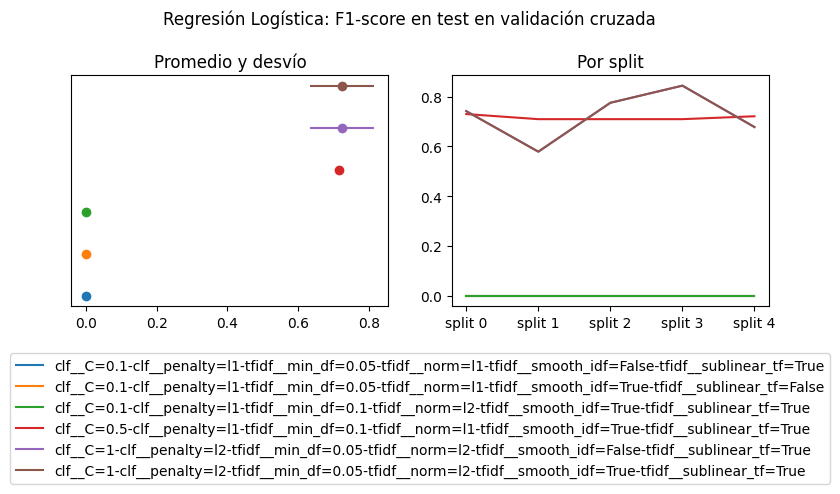

In [153]:
lr_gridsearch_cv_results2plot = build_results_df2plot(lr_gridsearch_cv_results)
plot_results(lr_gridsearch_cv_results2plot, clf="Regresión Logística", file_name="clf__lr_cv.png")

In [154]:
print_best_estimator_info(lr_gridsearch)


    - Best Cross-Validation score : 0.7237607205026027
    - Best parameters set:
	-- clf__C: 1
	-- clf__penalty: l2
	-- tfidf__min_df: 0.05
	-- tfidf__norm: l2
	-- tfidf__smooth_idf: False
	-- tfidf__sublinear_tf: True
    


In [209]:
selected_lr = lr_gridsearch_cv_results[
    lr_gridsearch_cv_results.index.str.contains("C=0.5")
    & lr_gridsearch_cv_results.index.str.contains("penalty=l1")
    & lr_gridsearch_cv_results.index.str.contains("min_df=0.1")
    & lr_gridsearch_cv_results.index.str.contains("norm=l1")
    & lr_gridsearch_cv_results.index.str.contains("smooth_idf=True")
    & lr_gridsearch_cv_results.index.str.contains("sublinear_tf=True")
]
selected_lr_params = "\n\t-- ".join(selected_lr.index.tolist()[0].split('-'))
print(f"""
    - Selected Cross-Validation score: {selected_lr.mean_test_score.values[0]}
    - Selected parameters set:\n\t-- {selected_lr_params}
""")


    - Selected Cross-Validation score: 0.7161004927266165
    - Selected parameters set:
	-- clf__C=0.5
	-- clf__penalty=l1
	-- tfidf__min_df=0.1
	-- tfidf__norm=l1
	-- tfidf__smooth_idf=True
	-- tfidf__sublinear_tf=True



# Feature Importance

In [224]:
def get_seleted_params(params:str) -> dict[str, dict[str,Any]]:
    selected_params = dict()
    key_value_params = [p.split("=") for p in params.split("\n\t-- ")]
    for key, value in key_value_params:
        try:
            value = eval(value)
        except:
            value = value
        clf, param = key.split("__")
        if clf in selected_params:
            selected_params[clf][param] = value
        else:
            selected_params[clf] = {param: value}
    return selected_params

def get_best_params(params: dict[str:Any]) -> dict[str, dict[str, Any]]:
    selected_params = dict()
    for key, value in params.items():
        clf, param = key.split("__")
        if clf in selected_params:
            selected_params[clf][param] = value
        else:
            selected_params[clf] = {param: value}
    return selected_params


## Multinomial Naive Bayes

### Selected Params

In [238]:
selected_nb_params = get_seleted_params(selected_nb_params)
selected_nb_pipeline = build_pipeline(pipeline_steps=[
    (
        "tfidf",
        TfidfVectorizer(lowercase=True, preprocessor=preprocess, **selected_nb_params["tfidf"]),
    ),
    (
        "clf",
        MultinomialNB(**selected_nb_params["clf"]
        )
    )
])
selected_nb_fi = selected_nb_pipeline.fit(X, y)

In [249]:
selected_nb_features = selected_nb_fi[0].vocabulary_
selected_nb_weights_neg = selected_nb_fi[1].feature_log_prob_[0:]
selected_nb_weights_pos = selected_nb_fi[1].feature_log_prob_[1:]

### Best Params

In [250]:
best_nb_params = get_best_params(nb_gridsearch.best_params_)
best_nb_pipeline = build_pipeline(pipeline_steps=[
    (
        "tfidf",
        TfidfVectorizer(lowercase=True, preprocessor=preprocess, **selected_nb_params["tfidf"]),
    ),
    (
        "clf",
        MultinomialNB(**selected_nb_params["clf"]
        )
    )
])
best_nb_fi = best_nb_pipeline.fit(X, y)

In [251]:
best_nb_features = best_nb_fi[0].vocabulary_
best_nb_weights_neg = best_nb_fi[1].feature_log_prob_[0:]
best_nb_weights_pos = best_nb_fi[1].feature_log_prob_[1:]

## Logistic Regression

### Selected Params

In [210]:
selected_lr_params = get_seleted_params(selected_lr_params)
selected_lr_pipeline = build_pipeline(pipeline_steps=[
    (
        "tfidf",
        TfidfVectorizer(lowercase=True, preprocessor=preprocess, **selected_lr_params["tfidf"]),
    ),
    (
        "clf",
        LogisticRegression(
            multi_class="ovr", solver="liblinear", random_state=2023, **selected_lr_params["clf"])
    )
])
selected_lr_fi = selected_lr_pipeline.fit(X, y)

In [212]:
selected_lr_features = selected_lr_fi[0].vocabulary_
selected_lr_weights  = selected_lr_fi[1].coef_

In [213]:
selected_lr_weights[selected_lr_weights>0]

array([0.8795013])

In [214]:
selected_lr_weights[selected_lr_weights<0]

array([-0.40178618])

### Best Params

In [232]:
best_lr_params = get_best_params(lr_gridsearch.best_params_)
best_lr_pipeline = build_pipeline(pipeline_steps=[
    (
        "tfidf",
        TfidfVectorizer(lowercase=True, preprocessor=preprocess, **best_lr_params["tfidf"]),
    ),
    (
        "clf",
        LogisticRegression(
            multi_class="ovr", solver="liblinear", random_state=2023, **best_lr_params["clf"])
    )
])
best_lr_fi = best_lr_pipeline.fit(X, y)

In [233]:
best_lr_features = best_lr_fi[0].vocabulary_
best_lr_weights  = best_lr_fi[1].coef_

In [234]:
best_lr_weights[best_lr_weights>0]

array([2.69355017e-01, 9.44334426e-02, 2.96841131e-01, 1.03737743e-01,
       1.73323480e-01, 4.11375641e-02, 3.69358946e-02, 3.00328223e-01,
       7.39042786e-02, 1.68855999e+00, 1.44788366e+00, 1.88458429e-02,
       1.13088041e-03, 7.22622112e-02, 1.26269805e-02, 1.69552298e-01,
       1.29364782e-01, 1.53945002e-01, 1.30305664e-01, 2.94905395e-02,
       4.63218941e-02, 6.49620163e-02, 6.95819944e-04, 9.94041058e-02,
       5.02910669e-04, 6.54455981e-02, 5.03338650e-02, 2.98837184e-02,
       3.72814853e-01, 2.54011298e-01, 1.14665112e-01, 1.68693174e-01,
       3.12249887e-02, 2.99528198e-02, 2.40092192e-02, 2.10501916e-01,
       7.94037828e-02, 7.59011332e-02, 6.94599646e-03, 3.34417791e-01,
       1.93296364e-01, 1.72536777e-01, 6.04305877e-02, 8.02048000e-02,
       3.34189476e-02, 2.84776706e-02, 1.97925292e-01, 9.29132610e-03,
       1.38581562e-01, 4.92596245e-02, 7.94948058e-02, 1.05531236e-01,
       1.19993473e-01, 1.09402611e-01, 4.70081718e-02, 3.53079018e-03,
      

In [229]:
weights[weights<0]

array([-9.23706456e-02, -1.92265070e-01, -1.22959938e-01, -9.03402904e-02,
       -2.01401946e-01, -5.24055401e-02, -1.88945961e-01, -2.01416135e-02,
       -7.10363520e-02, -4.72811373e-02, -9.57879060e-03, -5.03576607e-02,
       -1.50528609e-01, -1.81211200e-01, -5.92997600e-02, -1.18149603e-01,
       -1.94052181e-01, -1.91919238e-01, -5.43260520e-02, -6.28626951e-01,
       -4.05622829e-02, -1.61488917e-01, -1.51735627e-01, -6.37112473e-02,
       -3.35297724e-02, -7.02174725e-02, -1.14074454e-02, -1.09181727e-01,
       -1.37067297e-01, -1.96781122e-01, -1.52791559e-01, -1.42911712e-01,
       -5.71554647e-02, -2.97950562e-02, -7.79262835e-02, -2.92429177e-01,
       -4.51335362e-01, -3.80660410e-02, -2.58656543e-02, -5.55784529e-04,
       -2.37338342e-01, -6.15664998e-01, -1.52093167e-01, -1.51638337e-01,
       -2.15195423e-01, -2.76268548e-01, -9.91818988e-02, -1.39104611e-01,
       -9.31059535e-02, -1.53638215e-01, -8.30851175e-02, -1.26460249e-01,
       -8.37350713e-02, -

In [237]:
joblib.dump(best_lr_pipeline, "../models/best_lr_pipeline.joblib")

['../models/best_lr_pipeline.joblib']